## pipeline

In [1]:
import numpy as np
import os
import pickle
import copy
import edt
import matplotlib.pyplot as plt
import time
import cv2
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from skimage.metrics import adapted_rand_error

import torch
from torch import from_numpy as from_numpy
from torchsummary import summary

from func.run_pipeline_super_vox import segment_super_vox_3_channel, semantic_segment_crop_and_cat_3_channel_output, \
img_3d_erosion_or_expansion, segment_super_vox_2_channel, semantic_segment_crop_and_cat_2_channel_output, \
generate_super_vox_by_watershed, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, Cluster_Super_Vox, assign_boudary_voxels_to_cells_with_watershed, \
delete_too_small_cluster, reassign
from func.run_pipeline import segment, assign_boudary_voxels_to_cells, dbscan_of_seg, semantic_segment_crop_and_cat
from func.cal_accuracy import IOU_and_Dice_Accuracy, VOI
from func.network import VoxResNet, CellSegNet_basic_lite
from func.unet_3d_basic import UNet3D_basic
from func.ultis import save_obj, load_obj

### init model

In [2]:
# model=UNet3D_basic(in_channels = 1, out_channels = 3)
# load_path=''
# model=VoxResNet(input_channel=1, n_classes=3, output_func = "softmax")
# load_path=''
model=CellSegNet_basic_lite(input_channel=1, n_classes=3, output_func = "softmax")
load_path='output/model_Ovules.pkl'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CellSegNet_basic_lite(
  (conv1): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (conv2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bnorm1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule1): ResModule(
    (batchnorm_module): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule2): ResModule(
    (batchnorm_module): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_module): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (conv5): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
  (resmodule3): R

### dataset info

In [3]:
Ovules_data_dict = load_obj("dataset_info/Ovules_dataset_info")

### seg one img

parameter setting

In [4]:
# we do not input the whole raw image to the model one time but input raw image crops
crop_cube_size=128
stride=64

# hyperparameter for TASCAN, min touching area of two super pixels if they belong to the same cell
min_touching_area=30

choose a test image and load it

In [5]:
print("there are test imgs: "+str(Ovules_data_dict['test'].keys()))
case = 'N_435_final_crop_ds2.npz'
print("for test case "+str(case)+" : "+str(Ovules_data_dict['test'][case]))

there are test imgs: dict_keys(['N_441_final_crop_ds2.npz', 'N_590_final_crop_ds2.npz', 'N_294_final_crop_ds2.npz', 'N_593_final_crop_ds2.npz', 'N_435_final_crop_ds2.npz', 'N_511_final_crop_ds2.npz', 'N_522_final_crop_ds2.npz'])
for test case N_435_final_crop_ds2.npz : /data/CellSeg_dataset/Ovules_processed_thin_boundary/test/N_435_final_crop_ds2.npz


In [6]:
hf = np.load(Ovules_data_dict['test'][case])
raw_img = np.array(hf["raw"], dtype=np.float)
hand_seg = np.array(hf["ins"], dtype=np.float)
boundary_gt = np.array(hf["boundary"], dtype=np.float)
foreground_gt = np.array(hf["foreground"], dtype=np.float)

print("raw_img shape: "+str(raw_img.shape))
print("hand_seg shape: "+str(hand_seg.shape))
raw_img_shape = raw_img.shape
hand_seg_shape = hand_seg.shape

/tmp/ipykernel_31324/527985580.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  raw_img = np.array(hf["raw"], dtype=np.float)
/tmp/ipykernel_31324/527985580.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hand_seg = np.array(hf["ins"], dtype=np.float)
/tmp/ipykernel_31324/527985580.py:4: DeprecationWarning: `np.float` is a deprecat

raw_img shape: (194, 550, 555)
hand_seg shape: (194, 550, 555)


feed raw image crops to the model

In [7]:
# feed the raw img to the model
print('Feed raw img to model. Use different transposes')
raw_img_size=raw_img.shape
    
seg_foreground_comp = np.zeros(raw_img_size)
seg_boundary_comp = np.zeros(raw_img_size)

transposes = [[0,1,2]]#,[2,0,1],[0,2,1]]
reverse_transposes = [[0,1,2]]#,[1,2,0],[0,2,1]]

for idx, transpose in enumerate(transposes):
    print(str(idx+1)+": Transpose the image to be: "+str(transpose))
    with torch.no_grad():
        seg_img=\
        semantic_segment_crop_and_cat_3_channel_output(raw_img.transpose(transpose), model, device, crop_cube_size=crop_cube_size, stride=stride)
    seg_img_background=seg_img['background']
    seg_img_boundary=seg_img['boundary']
    seg_img_foreground=seg_img['foreground']
    torch.cuda.empty_cache()
    
    # argmax
    print('argmax', end='\r')
    seg=[]
    seg.append(seg_img_background)
    seg.append(seg_img_boundary)
    seg.append(seg_img_foreground)
    seg=np.array(seg)
    seg_argmax=np.argmax(seg, axis=0)
    # probability map to 0 1 segment
    seg_background=np.zeros(seg_img_background.shape)
    seg_background[np.where(seg_argmax==0)]=1
    seg_foreground=np.zeros(seg_img_foreground.shape)
    seg_foreground[np.where(seg_argmax==2)]=1
    seg_boundary=np.zeros(seg_img_boundary.shape)
    seg_boundary[np.where(seg_argmax==1)]=1
        
    seg_background=seg_background.transpose(reverse_transposes[idx])
    seg_foreground=seg_foreground.transpose(reverse_transposes[idx])
    seg_boundary=seg_boundary.transpose(reverse_transposes[idx])
        
    seg_foreground_comp+=seg_foreground
    seg_boundary_comp+=seg_boundary
print("Get model semantic seg by combination")
seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=np.int)
seg_foreground_comp = np.array(seg_foreground_comp>0, dtype=np.int)
seg_foreground_comp[seg_boundary_comp>0]=0
seg_background_comp = np.array(1 - seg_foreground_comp - seg_boundary_comp>0, dtype=np.int)

Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
Get model semantic seg by combination


/tmp/ipykernel_31324/4183907637.py:44: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=np.int)
/tmp/ipykernel_31324/4183907637.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informa

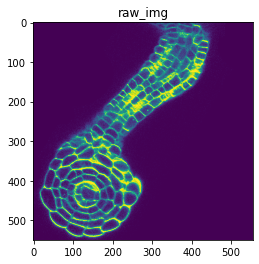

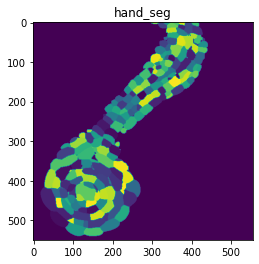

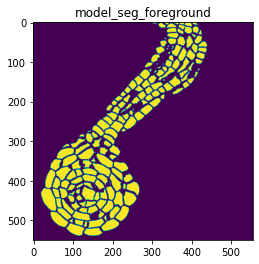

In [8]:
N=80

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[N,:,:])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[N,:,:]))
plt.figure()
plt.title("model_seg_foreground")
plt.imshow(seg_foreground_comp[N,:,:])

TASCAN

generate super vox by watershed

In [9]:
# Generate super vox by watershed
how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion, connectivity=min_touching_area)

In [10]:
print("There are "+str(len(np.unique(seg_foreground_super_voxel_by_ws)))+" super voxels")

There are 5829 super voxels


super voxel clustearing

In [11]:
# Super voxel clustearing
cluster_super_vox=Cluster_Super_Vox(min_touching_area=min_touching_area, min_touching_percentage=min_touching_percentage)
cluster_super_vox.fit(seg_foreground_super_voxel_by_ws)
seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img

get val_outlayer area of all vals: 0.3656485929993137

delete too small cells

In [12]:
# Delete too small cells
min_cell_size_threshold=10

seg_foreground_single_cell_with_boundary_delete_too_small = delete_too_small_cluster(seg_foreground_single_cell_with_boundary, threshold=min_cell_size_threshold)

assign boudary voxels to their nearest cells

In [13]:
# Assign boudary voxels to their nearest cells
seg_final=assign_boudary_voxels_to_cells_with_watershed(seg_foreground_single_cell_with_boundary_delete_too_small, seg_boundary_comp, seg_background_comp, compactness=1)

In [14]:
# Reassign unique numbers
# seg_final=reassign(seg_final)

see the final result

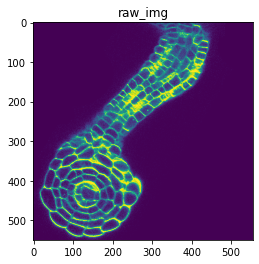

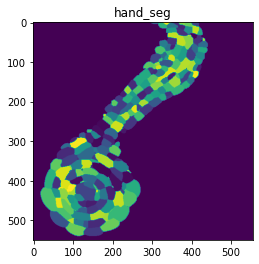

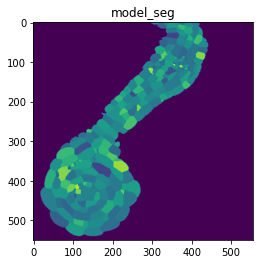

In [15]:
N=80
# print("There are "+str(len(np.unique(seg_final)))+" cells in model prediction")
# print("There are "+str(len(np.unique(hand_seg)))+" cells in hand seg")
plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[N,:,:])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[N,:,:]))
plt.figure()
plt.title("model_seg")
plt.imshow(reassign(seg_final[N,:,:]))

In [16]:
def colorful_seg(seg):
    unique_vals, val_counts = np.unique(seg, return_counts=True)
    
    background_val = unique_vals[np.argsort(val_counts)[::-1][0]]
    
    seg_RGB = []
    for i in range(seg.shape[0]):
        mask_gray = cv2.normalize(src=seg[i,:,:], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        seg_slice_RGB = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
        seg_RGB.append(seg_slice_RGB)
    seg_RGB = np.array(seg_RGB)
    
    for idx, unique_val in enumerate(unique_vals):
        print(str(idx/len(unique_vals)), end="\r")
        if unique_val == background_val:
            COLOR = np.array([0,0,0], dtype=int)
        else:
            COLOR = np.array(np.random.choice(np.arange(256), size=3, replace=False), dtype=int)
        
        locs = np.where(seg==unique_val)
        
        for i in range(3):
            seg_RGB[locs[0], locs[1], locs[2], i] = COLOR[i]
        
    return seg_RGB


In [17]:
seg_final_RGB = colorful_seg(seg_final)
hand_seg_RGB = colorful_seg(hand_seg)

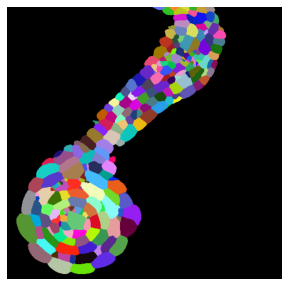

In [18]:
N=80

fig = plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(seg_final_RGB[N,:,:])
#plt.savefig('Ovules_seg_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)